### Imports

In [126]:
import numpy as np
import pandas as pd

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler, OrdinalEncoder

In [308]:
fp_train = "../tdt05-2021-challenge-2/challenge2_train.csv"
fp_test = "../tdt05-2021-challenge-2/challenge2_test.csv"

df_train = pd.read_csv(fp_train)  # 81.488% False, 18.512% True
df_test = pd.read_csv(fp_test)

In [295]:
x = df_train['f24']
x = x.unique()
x.sort()
print(x)

[-1.          0.075       0.15411035 ...  2.86356421  2.94745653
         nan]


In [323]:
Xtra = df_train.copy(deep=True)
Xtst = df_test.copy(deep=True)

Xtra[['f17', 'f24']].head(10)

,f17,f24
0,0.858315,0.834041
1,0.616743,0.686021
2,0.711389,1.141271
3,NaN,0.662382
4,0.572781,-1.000000
5,0.667236,0.749583
6,NaN,0.601041
7,NaN,0.946705
8,0.559368,0.491172
9,0.758056,0.601560


In [324]:
Xtra['f24'].replace(-1., np.nan, inplace=True)
Xtst['f24'].replace(-1., np.nan, inplace=True)

Xtra[['f17', 'f24']] = np.log(Xtra[['f17', 'f24']])
Xtst[['f17', 'f24']] = np.log(Xtst[['f17', 'f24']])

scl = StandardScaler()
Xtra[['f17', 'f24']] = scl.fit_transform(Xtra[['f17', 'f24']])
Xtst[['f17', 'f24']] = scl.transform(Xtst[['f17', 'f24']])

print(Xtra['f17'].std())
print(Xtra['f24'].std())

1.000012426296529
1.000012899148012


<AxesSubplot:ylabel='Frequency'>

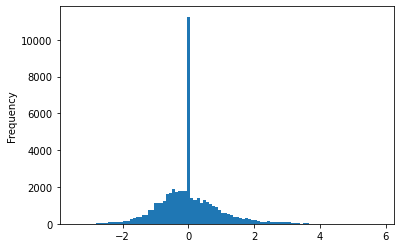

In [331]:
Xtra['f17'].plot.hist(bins=100)

In [329]:
Xtra[['f17', 'f24']] = Xtra[['f17', 'f24']].fillna(0)
Xtst[['f17', 'f24']] = Xtst[['f17', 'f24']].fillna(0)


In [314]:
Xtra[['f17', 'f24']].head(10)

,f17,f24
0,0.358712,-0.004939
1,-0.964554,-0.543123
2,-0.392971,0.858954
3,0.000000,-0.639716
4,-1.260613,0.000000
5,-0.649502,-0.299038
6,0.000000,-0.907410
7,0.000000,0.344084
8,-1.355485,-1.463482
9,-0.138592,-0.905029


In [318]:
print(Xtra['f17'].mean())
print(Xtra['f24'].mean())

-3.0127011996228247e-17
-1.0402345651527867e-16


In [ ]:
ordinal = ['f1', 'f2', 'f3', 'f5', 'f7', 'f10', 'f18', 'f19', 'f27']
numeric = ['f11', 'f17', 'f24', 'f28']
binary = ['f0', 'f4', 'f6', 'f25', 'f26']
cyclical = ['f16', 'f21']
nominal = ['f8', 'f9', 'f12', 'f14', 'f15', 'f22', 'f23'] # hexes
duplicate = ['f20']

num_ords = ['f3', 'f5', 'f7', 'f19', 'f27']
alpha_ords = ['f1', 'f2', 'f10', 'f18']

### Observations of similarity to Cat in dat 2

f1 is ord_5
f3 is ord_0
f10 is 0rd_4
f12 is nom_7
f13 is ord_3
f16 is month
f21 is day

In [119]:
a=[]
for i in binary:
    a.extend(df_train[i].dropna().unique())

print(a)

[1.0, 0.0, 'A', 'B', 0.0, 1.0, 'T', 'F', 'N', 'S']


In [124]:
bin_encoding = {float(0): 0, 'A':0, 'F':0, 'S':0, float(1):1, 'B':1, 'T':1, 'N':1}
for i in binary:
    print(df_train[i].head())
    print(df_train[i].map(bin_encoding).head())

0    1.0
1    0.0
2    NaN
3    1.0
4    1.0
Name: f0, dtype: float64
0    1.0
1    0.0
2    NaN
3    1.0
4    1.0
Name: f0, dtype: float64
0    A
1    A
2    A
3    A
4    A
Name: f4, dtype: object
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: f4, dtype: float64
0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: f6, dtype: float64
0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: f6, dtype: float64
0    T
1    T
2    T
3    T
4    T
Name: f25, dtype: object
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: f25, dtype: float64
0    N
1    N
2    N
3    N
4    N
Name: f26, dtype: object
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: f26, dtype: float64


In [ ]:
feat_df = df_train.copy(deep=True).drop(['id', 'target', 'f27'])


In [349]:
def clean_feature_engineer(fp_train, fp_test):
    original_train = pd.read_csv(fp_train)
    original_test = pd.read_csv(fp_test)

    y_tr = original_train['target'].apply(lambda x: int(x) if pd.notnull(x) else x)
    X_tr = original_train.copy(deep=True)
    X_ts = original_test.copy(deep=True)

    lb_enc = LabelEncoder()
    ord_enc = OrdinalEncoder()
    oh_enc = OneHotEncoder()


    # BINARY
    bin_encoding = {float(0): 0, 'A':0, 'F':0, 'S':0, float(1):1, 'B':1, 'T':1, 'N':1}
    for col in binary:
        X_tr[col] = X_tr[col].map(bin_encoding)
        X_ts[col] = X_ts[col].map(bin_encoding)

    # Numericals
    numericals = ['f11', 'f17', 'f24', 'f28']
    bell_curve = ['f11', 'f28']
    long_tail = ['f17', 'f24'] # F24 has -1 as null values. Remove before scaling

    #BELL CURVES

    scl = StandardScaler()
    X_tr[['f11', 'f28']] = scl.fit_transform(X_tr[['f11', 'f28']])
    X_ts[['f11', 'f28']] = scl.transform(X_ts[['f11', 'f28']])

    #since we have normalized the bellcurve around 1, we believe we can impute 0 in Null's
    X_tr[['f11', 'f28']] = X_tr[['f11', 'f28']].fillna(value=0)
    X_ts[['f11', 'f28']] = X_ts[['f11', 'f28']].fillna(value=0)

    # LONG TAILS. Strat: Log the shit out of them to push onto bell curve, then scale them.
    X_tr[['f24']].replace(-1.0, np.nan, inplace=True)
    X_ts[['f24']].replace(-1.0, np.nan, inplace=True)

    X_tr[['f17', 'f24']] = np.log(X_tr[['f17', 'f24']])
    X_ts[['f17', 'f24']] = np.log(X_ts[['f17', 'f24']])

    scl = StandardScaler()
    X_tr[['f17', 'f24']] = scl.fit_transform(X_tr[['f17', 'f24']])
    X_ts[['f17', 'f24']] = scl.transform(X_ts[['f17', 'f24']])

    #since we have normalized the bellcurve around 1, we believe we can impute 0 in Null's.
    # Not really sure about this one though.
    X_tr[['f17', 'f24']] = X_tr[['f17', 'f24']].fillna(value=0)
    X_ts[['f17', 'f24']] = X_ts[['f17', 'f24']].fillna(value=0)


# ORDINAL (OrdinalEncoder)
    ordinals = ['f1_0', 'f1_1', 'f2', 'f3', 'f5', 'f7', 'f10', 'f13', 'f18', 'f19', 'f27']
    numerical_ordinals = ['f3','f5','f7','f19','f27']
    usable_ordinals = ['f3','f5','f7','f27']
    alphabetical_ordinals = ['f1_0', 'f1_1', 'f2', 'f10', 'f13', 'f18']
    CAPS_ONLY = ['f10', 'f18']
    lower_only = ['f2', 'f13']
    MiX = ['f1_0', 'f1_1']

    assert set(alphabetical_ordinals).isdisjoint(numerical_ordinals)
    assert set(CAPS_ONLY).isdisjoint(lower_only)
    assert set(CAPS_ONLY).isdisjoint(MiX)
    assert set(MiX).isdisjoint(lower_only)

    # split f1 on letter
    X_tr['f1_0'] = X_tr['f1'].apply(lambda x: x[0] if type(x) is str else x)
    X_tr['f1_1'] = X_tr['f1'].apply(lambda x: x[0] if type(x) is str else x)
    X_ts['f1_0'] = X_ts['f1'].apply(lambda x: x[0] if type(x) is str else x)
    X_ts['f1_1'] = X_ts['f1'].apply(lambda x: x[0] if type(x) is str else x)

    X_tr.drop(['f1'], axis=1, inplace=True)
    X_ts.drop(['f1'], axis=1, inplace=True)


    for col_name in ordinals:
        if col_name in numerical_ordinals and col_name not in usable_ordinals:
            X_tr[col_name] = X_tr[col_name].apply(lambda x: x*10 if not pd.notnull(x) else x)
            X_ts[col_name] = X_ts[col_name].apply(lambda x: x*10 if not pd.notnull(x) else x)
        elif col_name in alphabetical_ordinals:
            if col_name in CAPS_ONLY:
                X_tr[col_name] = X_tr[col_name].apply(lambda x: ord(x)-ord('A') if pd.notnull(x) else x)
                X_ts[col_name] = X_ts[col_name].apply(lambda x: ord(x)-ord('A') if pd.notnull(x) else x)
            elif col_name in lower_only:
                X_tr[col_name] = X_tr[col_name].apply(lambda x: ord(x)-ord('a') if pd.notnull(x) else x)
                X_ts[col_name] = X_ts[col_name].apply(lambda x: ord(x)-ord('a') if pd.notnull(x) else x)
            elif col_name in MiX:
                X_tr[col_name] = X_tr[col_name].apply(lambda x: (ord(x)-ord('a') + (ord('Z') - ord('A') + 1) if x.islower() else ord(x)-ord('A')) if pd.notnull(x) else x)
                X_ts[col_name] = X_ts[col_name].apply(lambda x: (ord(x)-ord('a') + (ord('Z') - ord('A') + 1) if x.islower() else ord(x)-ord('A')) if pd.notnull(x) else x)
            else:
                raise ValueError("Something wrong with the sets...")


    # NOMINAL (OneHotEncoder)

    high_cardinality_noms = [i for i in nominal if X_tr[i].nunique() > 10] # Hexes
    low_cardinality_noms = [i for i in nominal if i not in high_cardinality_noms]

    # Onehot for low cardinality Noms

    X_tr = X_tr.join(pd.get_dummies(X_tr[low_cardinality_noms], dummy_na=False, drop_first=False))
    X_tr.drop(low_cardinality_noms, axis=1, inplace=True)

    X_ts = X_ts.join(pd.get_dummies(X_ts[low_cardinality_noms], dummy_na=False, drop_first=False))
    X_ts.drop(low_cardinality_noms, axis=1, inplace=True)

    # ToDo: need to do ordinal on this
    for nom in high_cardinality_noms:
        X_tr[nom] = X_tr[nom].apply(lambda x: int(x[0], base=16)/16 if pd.notnull(x) else x)

    # CYCLICAL

    ## We believe f16 is month
    X_tr['f16_sin'] = np.sin((X_tr['f16']-1)*(2.*np.pi/12))
    X_tr['f16_cos'] = np.cos((X_tr['f16']-1)*(2.*np.pi/12))

    X_ts['f16_sin'] = np.sin((X_ts['f16']-1)*(2.*np.pi/12))
    X_ts['f16_cos'] = np.cos((X_ts['f16']-1)*(2.*np.pi/12))

    X_tr['f16_sin'].fillna(0, inplace=True)
    X_tr['f16_cos'].fillna(0, inplace=True)
    X_ts['f16_sin'].fillna(0, inplace=True)
    X_ts['f16_cos'].fillna(0, inplace=True)

    X_tr.drop(['f16'], axis=1, inplace=True)
    X_ts.drop(['f16'], axis=1, inplace=True)

    ## We believe f21 is dayOfWeek
    X_tr['f21_sin'] = np.sin((X_tr['f21']-1)*(2.*np.pi/7))
    X_tr['f21_cos'] = np.cos((X_tr['f21']-1)*(2.*np.pi/7))

    X_ts['f21_sin'] = np.sin((X_ts['f21']-1)*(2.*np.pi/7))
    X_ts['f21_cos'] = np.cos((X_ts['f21']-1)*(2.*np.pi/7))

    X_tr['f21_sin'].fillna(0, inplace=True)
    X_tr['f21_cos'].fillna(0, inplace=True)
    X_ts['f21_sin'].fillna(0, inplace=True)
    X_ts['f21_cos'].fillna(0, inplace=True)

    X_tr.drop(['f21'], axis=1, inplace=True)
    X_ts.drop(['f21'], axis=1, inplace=True)

    # DUPLICATES
    X_tr.drop(['f27'], axis=1, inplace=True)
    X_ts.drop(['f27'], axis=1, inplace=True)


    return X_tr, X_ts, y_tr


x, _, _ = clean_feature_engineer(fp_train, fp_test)
x.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log


,id,target,f0,f2,f3,f4,f5,f6,f7,f8,...,f9_red,f9_white,f9_yellow,f22_B,f22_G,f22_R,f16_sin,f16_cos,f21_sin,f21_cos
0,0,0,1.0,4.0,3.0,0.0,NaN,0.0,6.0,0.5625,...,0,0,1,0,0,1,0.500000,0.866025,0.974928,-0.222521
1,1,0,0.0,2.0,1.0,0.0,7.0,1.0,4.0,0.5625,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,1.000000
2,2,0,NaN,0.0,1.0,0.0,10.0,1.0,6.0,0.6250,...,0,1,0,0,1,0,0.866025,0.500000,0.974928,-0.222521
3,3,1,1.0,2.0,3.0,0.0,7.0,1.0,1.0,0.0625,...,0,0,1,0,1,0,0.866025,-0.500000,0.000000,1.000000
4,4,0,1.0,2.0,3.0,0.0,7.0,0.0,6.0,0.6875,...,0,0,1,1,0,0,0.500000,0.866025,0.000000,1.000000


In [350]:
pd.set_option('display.max_colwidth', None)
x.describe()


,id,target,f0,f2,f3,f4,f5,f6,f7,f8,...,f9_red,f9_white,f9_yellow,f22_B,f22_G,f22_R,f16_sin,f16_cos,f21_sin,f21_cos
count,50000.000000,50000.000000,48541.000000,48561.000000,48512.000000,48502.000000,38383.000000,48510.000000,48475.000000,48510.000000,...,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000
mean,24999.500000,0.185120,0.629138,2.437532,1.943643,0.088800,8.293932,0.535993,4.102960,0.457611,...,0.268580,0.234080,0.159260,0.08794,0.345080,0.536720,7.464251e-02,-0.020610,-0.060345,0.016464
std,14433.901067,0.388399,0.483040,1.862271,0.852986,0.284458,2.500502,0.498708,1.854649,0.285804,...,0.443225,0.423427,0.365922,0.28321,0.475399,0.498655,6.231342e-01,0.759294,0.725115,0.663412
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-1.000000e+00,-1.000000,-0.974928,-0.900969
25%,12499.750000,0.000000,0.000000,1.000000,1.000000,0.000000,7.000000,0.000000,3.000000,0.187500,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-5.000000e-01,-0.866025,-0.781831,-0.222521
50%,24999.500000,0.000000,1.000000,2.000000,2.000000,0.000000,7.000000,1.000000,5.000000,0.437500,...,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.224647e-16,0.000000,0.000000,-0.222521
75%,37499.250000,0.000000,1.000000,4.000000,3.000000,0.000000,11.000000,1.000000,6.000000,0.687500,...,1.000000,0.000000,0.000000,0.00000,1.000000,1.000000,8.660254e-01,0.866025,0.781831,0.623490
max,49999.000000,1.000000,1.000000,5.000000,3.000000,1.000000,11.000000,1.000000,6.000000,0.937500,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000e+00,1.000000,0.974928,1.000000


In [351]:
x.dtypes

id             int64
target         int64
f0           float64
f2           float64
f3           float64
f4           float64
f5           float64
f6           float64
f7           float64
f8           float64
f10          float64
f11          float64
f12          float64
f13          float64
f14          float64
f15          float64
f17          float64
f18          float64
f19          float64
f20          float64
f23          float64
f24          float64
f25          float64
f26          float64
f28          float64
f1_0         float64
f1_1         float64
f9_black       uint8
f9_green       uint8
f9_red         uint8
f9_white       uint8
f9_yellow      uint8
f22_B          uint8
f22_G          uint8
f22_R          uint8
f16_sin      float64
f16_cos      float64
f21_sin      float64
f21_cos      float64
dtype: object

In [346]:
x['f13'].unique()

array(['h', 'g', 'c', 'a', 'm', 'e', 'n', 'k', nan, 'b', 'i', 'o', 'd',
       'f', 'j', 'l'], dtype=object)